This notebook is very loosely based on a presentation I did for a customer around an evaluation of various machine learning technologies for detecting faces in video streams or photos. For the most part the below is an illustration around how certain face detection technologies can be easily thrown off if the subject is looking in a particular direction, wearing a hat, has a beard, etc. I.e. it's very easy to find examples that certain face detection technologies will struggle with. For the sake of expediency I didn't include all the technologies we reviewed or even discussed, just the final winner, an incumbent technology and "almost as good" option that may still find itself being used in the final solution we build for the client. 

The examined models are "pre-trained" in that they've already been trained on a large number of faces, and can be used "out of the box" for a demonstration like this and "can" be used for many commercial applications as well. HOWEVER, given the recurring problem of facial recognition models being trained on fairly homegenous datasets, it would be wise to "fine-tune" the model(s) where you effectively augment the model with new data in order to increase its effectiveness for your use case. In particular, the MobileNet SSD should be trained more to be used in a production use case, while this instance of MTCNN probably won't need it due to how extensively it's been trained. If you look at the reference for Facenet-PyTorch in the comments you can read more around how this particular version of MTCNN was trained. 

In [1]:
# import our file libraries 

%matplotlib inline
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import time
import cv2
import torchvision
import torchvision.transforms as T 
import numpy as np

# import helper classes 
# these are external python scripts that I push a lot of code to make this notebook easier to read
from processing import ImageProcessing as preprocess
from helper import Helper as helper 
from MobilenetSSD import SSD_Detector

In [2]:

# instantiate the helper class with a variety of functions related to displaying photos 
helper_functions = helper()


# instantiate a class specifically for the MobileNet SSD face detector 
SSD_methods = SSD_Detector()




In [3]:
# sample files 
# add more examples 

picard = 'images/picard_hair.jpg'
zebra = 'images/zebra.jpg'
kd = 'images/KD.jpeg'
jlo = 'images/jlo.jpeg'
picard_hat = 'images/picard_hat.jpg'


#### We'll start with Haar Cascade via OpenCV

* OpenCV is a Python library originally created by Intel for photo processing and computer vision. It's been around for over 20 years and is still being updated, despite it's limitations it's easy to use and effective enough for most scenarios
* Haar Cascade is a facial detection approach that is around 20 years old and it has issues with false positives, off axis photos/photos where the person isn't looking directly into the camera. However, given that it was created when hardware was significantly slower than it is now, it is very fast on modern hardware and still has its place in modern solutions. 





In [4]:
# first we create the model
# the XML file has the "pretrained" model data that enables the model to detect a face 
# there are actually a number of different data files, e.g. one that detects eyes that you can use to augment
# your detections, but for the sake of this demo, we'll just focus on generating the box around the person's face.
# The haar cacade files can be downloaded from here: https://github.com/opencv/opencv/tree/master/data/haarcascades


# create the model 
detector = cv2.CascadeClassifier('hcdata/haarcascade_frontalface_default.xml') # creates the model 




In [5]:
# this function will use the model to a) detect the face b) put a bounding box around the face


def face_cascade(photo):
    # read in image and convert to grayscale
    img = cv2.imread(photo)
    grayscale_photo = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # detect faces 
    faces = detector.detectMultiScale(grayscale_photo, 1.3, 5)
    
    if len(faces): #check for empty list for instance where no face detected 
        print(faces)
        for (x,y,w,h) in faces:
            return cv2.rectangle(grayscale_photo,(x,y),(x+w,y+h),(255,0,0),2)        
    else:
        return img 


[[ 55  83 149 149]]
CPU times: user 659 ms, sys: 90.2 ms, total: 749 ms
Wall time: 343 ms


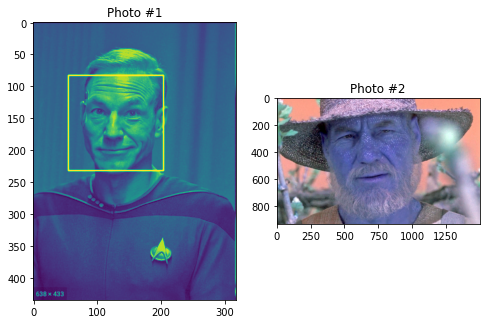

In [6]:
%%time

# now we will run face detection and generate bounding boxes for two photos
# the colors will be a bit wonky because of how openCV shifts the colors of the photos
# prior to running facial detection. Note: it's relatively easy to shift the colors back to
# normal

a = face_cascade(picard)
b = face_cascade(picard_hat)
helper_functions.plot_images(a, b)

As you can see the model detected Captain Picard's face in the first photo, but not in the second photo. This is because the beard, the hat and the foilage stymied the model. Let's look at another example 

[[413 202 456 456]]
CPU times: user 851 ms, sys: 31.9 ms, total: 883 ms
Wall time: 227 ms


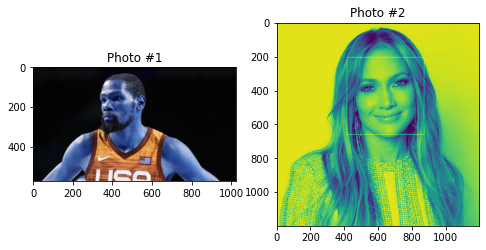

In [7]:
%%time

a = face_cascade(kd)
b = face_cascade(jlo)
helper_functions.plot_images(a, b)

In this example, the model had no problems detecting J. Lo's face, but struggled with Kevin Durant's because he's looking to our left, his right. It's worth noting that while Haar Cascade can still score in the low 90% range on a group of photos as far as accurately detecting faces, it's fairly easy to find a photo that will cause it to return a false negative. I.e. I just Googled celebrities and picked one of KD looking to his right and another with Picard wearing a hat. Still, if all you needed to do was trigger a camera to take a photo or trip some other sort of sensor when someone walked past a camera AND it was just meant to augment the efforts of humans monitoring the same area, you could still build an effective solution with haar cascade. 

In [8]:
# let's look at the MTCNN neural network approach for detecting faces 
# the knock on MTCNN is that it can be very slow, however, the below is the
# facenet-pytorch version, which is relativly fast, especially if you use GPU acceleration 
# you can use "help(MTCNN)"" to find out details on the hyperparameters below and all the different ways
# you can implement it 


mtcnn = MTCNN(160, 30, 20, [0.6, 0.7, 0.7], 0.709, True, True, 'Largest', False).eval()


In [9]:
# when passed a file path to a photo this function will use MTCNN to detect the face
# MTCNN will return x, y coordinates for a box around the person's face + key facial features
# and we will use the PIL (Python Imaging Library) to then draw a bounding box around the face 
# and matplotlib to render the photo + the bounding box. 


def mtcnn_detector(file_path):
    photo = Image.open(file_path)
    
    boxes, probs, points = mtcnn.detect(photo, landmarks=True)
    img_draw = photo.copy()
    draw = ImageDraw.Draw(img_draw)
    for i, (box, point) in enumerate(zip(boxes, points)):
        draw.rectangle(box.tolist(), width=5)
        for p in point:
            draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10)
    plt.imshow(img_draw)

CPU times: user 355 ms, sys: 87 ms, total: 442 ms
Wall time: 290 ms


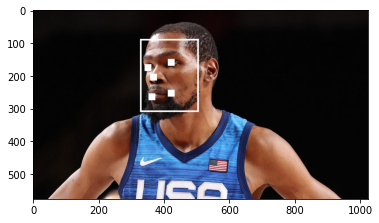

In [10]:
%%time
# what happens if we try and run face detection on KD?

x = mtcnn_detector(kd)

CPU times: user 994 ms, sys: 220 ms, total: 1.21 s
Wall time: 737 ms


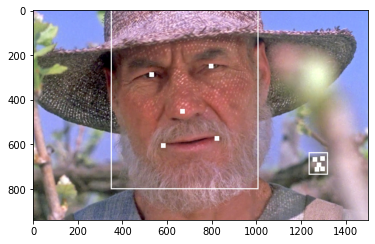

In [11]:
%%time

# what if we try to generate detection on Picard in the hat?
x = mtcnn_detector(picard_hat)



It's worth noting that we do have the small box to the right, which is definitely a false positive, but, in a photo recognition scenario we can use hyperparameters (select largest=True) to throw that result away. 

One of the reasons that MTCNN performs so much better than Haar Cascade is because it's actually three different neural nets performing in sequence, the first determines where a bounding boxes should go (if any at all) and the next two neural nets fine tune the x, y coordinates of the bounding box, facial landmarks and the like. 

#### What about speed?

As was mentioned before, Haar Cascade is significantly faster than MTCNN, what does that look like in real life? Let's illustrate this via looking at wall times for detecting a face in the same image. In the examples below, we'll just run the code to detect faces, but won't run the code to draw the bounding boxes. 

In [12]:
%%time 

# detect a face in the Picard with hair image 

a = face_cascade(picard)

[[ 55  83 149 149]]
CPU times: user 39.3 ms, sys: 1.82 ms, total: 41.1 ms
Wall time: 10.2 ms


In [13]:
%%time

# MTCNN requires use to use the Pillow library to read in the file and convert it to a blob 
# before passing it to the detector 

photo = Image.open(picard)
boxes, probs, points = mtcnn.detect(photo, landmarks=True)


CPU times: user 93.1 ms, sys: 13.9 ms, total: 107 ms
Wall time: 70.6 ms


As we can see, Haar Cascade is nearly 5x as fast as MTCNN when run on my fairly typical developer's MacBook. I.e. the increased accuracy comes with a price. 


Another technology that was strongly considered was the MobileNet SSD running on OpenCV's DNN module, the key reason being that it's faster than MTCNN and almost as accurate. Note that installing it requires a few extra steps, namely, you'll have to download the model and weight files to your local machine from here: https://github.com/chuanqi305/MobileNet-SSD



In [14]:
%%time

# initialized detector by reading in model + weights 
# the SSD model wasn't trained on the most diverse dataset, so we will probably need to retrain 
# prior to deployment 


detector = cv2.dnn.readNetFromCaffe("models/deploy.prototxt.txt",\
                                    "models/res10_300x300_ssd_iter_140000.caffemodel")




CPU times: user 13.4 ms, sys: 17.6 ms, total: 31 ms
Wall time: 32 ms


In [15]:
# method for reading in the file, re-sizing and calculating the updated aspect ratio
# resizing the file because SSD expects a 300 x 300 file 
# generating the variables with aspect ratio information for use in creating bounding boxes 


def SSD(file):
    image = cv2.imread(file)
    base_img = image.copy() # used for placing detection boxes over original image 
    original_size = base_img.shape
    target_size = (300, 300)
    image = cv2.resize(image, target_size)
    aspect_ratio_x = (original_size[1] / target_size[1])
    aspect_ratio_y = (original_size[0] / target_size[0])
    
    return image, base_img, original_size, aspect_ratio_x, aspect_ratio_y 
    


In [16]:
# this method takes in a file and runs face detection on it 


def SSD_Detector(image):
    imageBlob = cv2.dnn.blobFromImage(image = image)
    detector.setInput(imageBlob)
    detections = detector.forward()
    
    return detections 
    
  

In [17]:
# let's start by reading our now familiar photo of Kevin Durant and
# and taking the photo through some preprocessing steps 

ssd_kd, base_img, size, aspect_ratio_x, aspect_ratio_y = SSD(kd) 


# now we pass the photo to the SSD based face detector 
faces = SSD_Detector(ssd_kd)


In [18]:
# the detector returns an array so we pass said array + the dimensional data + the image to an 
# external class that will unpack the array to a Pandas data frame, it's fairly standard stuff so 
# I don't need to have it in the notebook 

face_data = SSD_methods.SSD_Data(faces) 

# let's view the data frame and see how many faces the model identified, as well as the coordinates for each
# bounding box 
face_data.head()

,img_id,is_face,confidence,left,top,right,bottom
0,0.0,1.0,0.995194,0.330312,0.146656,0.490125,0.534152


Id  0
Confidence:  99.52 %


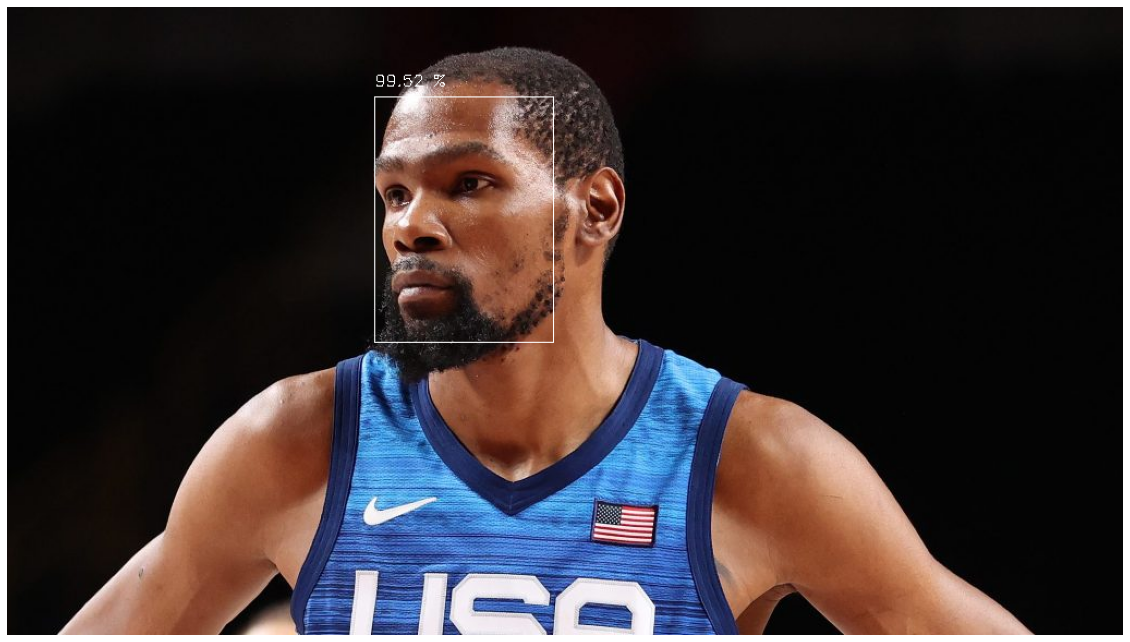

In [19]:
# now that we have the detection data frame, we pass it along with some of the dimensional
# data to another external method that will render the photo, along with a bounding box and text
# for the % confidence around the detected face. It's well over a dozen lines of code, so I put
# that method in the external SSD script 


SSD_methods.show_image(face_data, base_img, aspect_ratio_y, aspect_ratio_x)




As we can see, MobiletNet SSD had no problems detecting KD's face, but what happens if we try and use to detect the face in a photo of a certain Starship Captain? 

Id  0
Confidence:  99.79 %


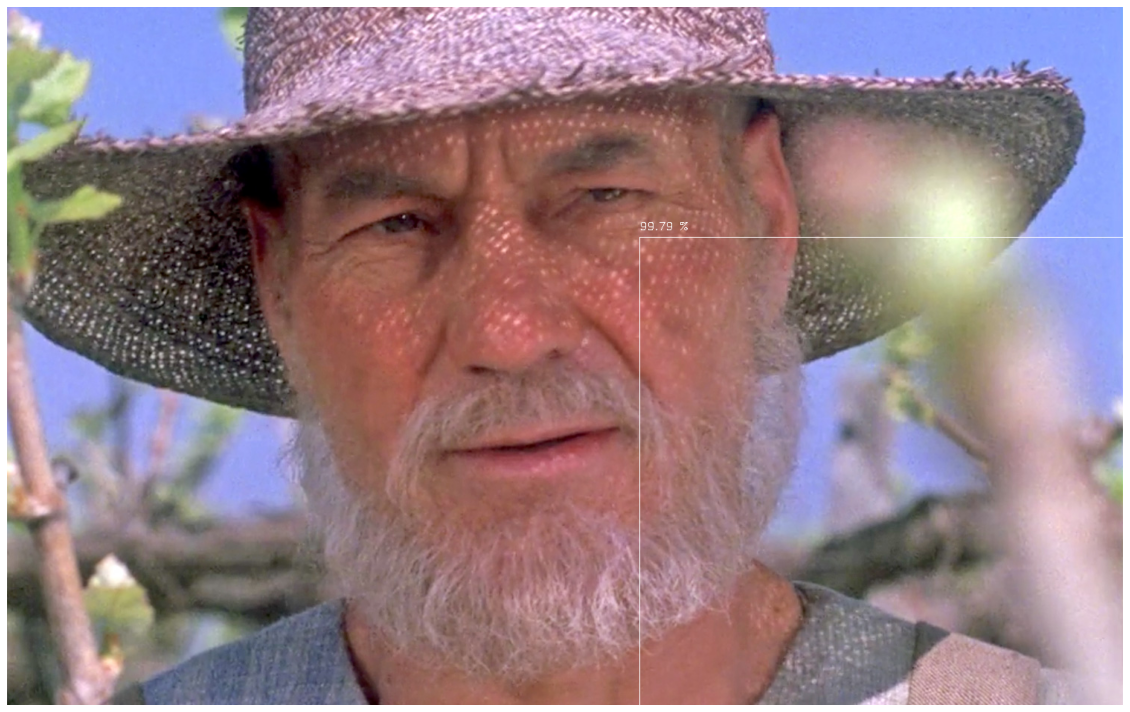

In [20]:

# initial processing 
ssd_picard, base_img, size, aspect_ratio_x, aspect_ratio_y = SSD(picard_hat)

# now we pass the photo to the SSD based face detector 
picard_faces = SSD_Detector(ssd_picard)

# get the data frame with the data on the face detections 
picard_data = SSD_methods.SSD_Data(picard_faces) 


# show the image 
SSD_methods.show_image(picard_data, base_img, aspect_ratio_y, aspect_ratio_x)


As you can see the model correctly determined that there was a face in the photo, unfortunately it placed the box
in the wrong place. Meaning: if we were using this model to crop the face out of the photo for facial recognition, the photos wouldn't match in this case because it cropped the wrong part of the photo. That being said, this doesn't mean that this model can't still be very useful, if you were able to control photo quality, fine tune it, etc., you could build a solution that would outperform Haar Cascade and be faster than MTCNN. 


In [21]:
%%time

# what does speed look like? For this test we'll include both the detection + parsing out the coordinate data
# since MTCNN does all of that in one go.


# now we pass the photo to the SSD based face detector 
picard_faces = SSD_Detector(ssd_picard)

# get the data frame with the data on the face detections 
picard_data = SSD_methods.SSD_Data(picard_faces) 




CPU times: user 79.3 ms, sys: 8.08 ms, total: 87.3 ms
Wall time: 25.2 ms


For reference the Haar Cascade model ran in about 12ms and MTCNN in 67ms, which makes SSD more than twice as fast as MTCNN, but still slower than Haar Cascade. 

To wrap this up, these are just a couple of the face detection options I looked at for a facial recognition solution. While MTCNN was the clear winner among the three (and some other options we tested), Haar Cascade and SSD are still viable options in certain instances where accuracy isn't as much of a factor or you can control how the photos are captured. In particular MobileNet SSD either in the form I used or some of the newer variants created by Google are definitely worth considering, especially if you're able to retrain those neural networks to fit your use cases.


#### References: 
* [Facenet-Pytorch](https://github.com/timesler/facenet-pytorch)
* [Pyimagesearch](https://pyimagesearch.com/start-here/) 